## The Golden Cross: A Moving Average Crossover Strategy

In this tutorial, we will build a classic algorithmic trading strategy known as the **Moving Average Crossover**. 

#### What is this strategy? (The ELI12 Version)

Imagine a man walking a dog on a leash in a park. 

1.  **The Man (The Long-Term Trend):** He walks slowly and steadily. He doesn't change direction quickly. In our code, this is the **200-Day Moving Average**.
2.  **The Dog (The Short-Term Trend):** The dog is energetic. It runs back and forth, reacting to squirrels and noises. In our code, this is the **50-Day Moving Average**.

**The Strategy Logic:**
*   **The Golden Cross (BUY):** When the Dog runs *ahead* of the Man (crosses from below to above), it suggests the excitement is picking up, and the pair is moving forward. We buy the stock.
*   **The Death Cross (SELL):** When the Dog falls *behind* the Man (crosses from above to below), it suggests the energy is lost. We sell the stock.


#### cheetsheet - to run this notebook
```
uv venv .venv --python 3.12
source .venv/bin/activate

uv pip install --upgrade google-genai
uv pip install yfinance pandas tabulate
uv pip install jupyterlab pandas numpy
uv pip install ipykernel     # ipykernel b 
uv pip install ipywidgets
uv pip install joblib        # for efficiently caching large Python objects (like pandas DataFrames) to disk

## Register the Kernel with Jupyter
## Next, you need to execute a command to register the Python interpreter from your .venv as an available kernel inside Jupyter.

python -m ipykernel install --user --name=uv_project --display-name="Python (uv project)"
   --user: Installs the kernel for your current user.
   --name: The technical name for the kernel (used internally).

jupyter notebook
```

#### Organization of the `Moving Average Crossover` code  

**Main Execution Block**
```
# 1. Configuration (Set these variables or ensure they are set by widgets)
SHORT_WINDOW = 50   # The Dog (50 days or 20 days)
LONG_WINDOW = 200   # The Man (200 days or 100 days)

# 2. Fetch data (This uses the user-selected dates/ticker)
# Data will be loaded from cache if it exists.
data = fetch_stock_data(TICKER, START_DATE, END_DATE) 

# 3. GENERATE SIGNALS (CRITICAL STEP: This adds the MA columns)
data = generate_signals(data, SHORT_WINDOW, LONG_WINDOW) 

# 4. Plot Data (Now the MA columns exist and the plot can run without KeyErrors)
plot_ma_crossover(data, TICKER, SHORT_WINDOW, LONG_WINDOW)
```

#### Setup and Dependency Import

**Libraries used:**
*   **`yfinance`**: A popular open-source library to download stock data from Yahoo Finance for free.
*   **`pandas`**: The excel-killer. It creates "DataFrames" (tables) to manipulate structured data.
*   **`numpy`**: The math engine. It handles arrays and high-speed calculations.
*   **`matplotlib`**: The plotting library used to draw charts.

In [6]:
# Install yfinance if you haven't already (uncomment the line below)
# !pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# This line ensures charts look nice in Jupyter
%matplotlib inline 
plt.style.use('fivethirtyeight') # Making the charts look professional  


**Data Fetching using `yfinance`:**
*   `yf.download(ticker, start, end)`: Fetches historical data. 
    *   It returns a **DataFrame**.
    *   Think of a DataFrame as a sophisticated `struct` containing multiple arrays (columns) that share a common index (dates).  

data = yf.download(ticker, start="2018-01-01", end="2024-01-01")  

### Interactive Ticker Selection

In [86]:
# Interactive Ticker Selection

import ipywidgets as widgets
from IPython.display import display

# Define the set of available tickers
TICKER_OPTIONS = ['NVDA', 'GOOG', 'SPY', 'TSLA', 'AAPL', 'MSFT', 'META', 'CRCL', 'ORCL', 'HOOD', 'AMD', 'JEPQ', 'BND' ]

# Create the dropdown widget
ticker_dropdown = widgets.Dropdown(
    options=TICKER_OPTIONS,
    value='NVDA',
    description='Select Ticker:',
    disabled=False,
)

# Function to run when the selection changes
def update_ticker(change):
    # This assigns the selected value to a variable named TICKER
    global TICKER 
    TICKER = change.new
    print(f"Ticker set to: {TICKER}")

# Display the widget and link it to the update function
ticker_dropdown.observe(update_ticker, names='value')

# Initialize the global TICKER variable to the default value
TICKER = ticker_dropdown.value

display(ticker_dropdown)

Dropdown(description='Select Ticker:', options=('NVDA', 'GOOG', 'SPY', 'TSLA', 'AAPL', 'MSFT', 'META', 'CRCL',…

### Interactive Duration Selection

In [87]:
# Interactive Duration Selection (Dynamic Dates)
import datetime as dt
import ipywidgets as widgets
from IPython.display import display
from dateutil.relativedelta import relativedelta # Requires uv pip install python-dateutil

# 1. Define the End Date (Today)
TODAY = dt.datetime.now() 
END_DATE = TODAY.strftime('%Y-%m-%d') 

# 2. Calculate Dynamic Start Dates
# --- Monthly / Yearly Calculations (using relativedelta for precision) ---
START_DATE_20Y = (TODAY - relativedelta(years=20)).strftime('%Y-%m-%d')
START_DATE_7Y = (TODAY - relativedelta(years=7)).strftime('%Y-%m-%d')
START_DATE_5Y = (TODAY - relativedelta(years=5)).strftime('%Y-%m-%d')
START_DATE_3Y = (TODAY - relativedelta(years=3)).strftime('%Y-%m-%d')
START_DATE_2Y = (TODAY - relativedelta(years=3)).strftime('%Y-%m-%d')
START_DATE_1Y = (TODAY - relativedelta(years=1)).strftime('%Y-%m-%d')

START_DATE_6M = (TODAY - relativedelta(months=6)).strftime('%Y-%m-%d')
START_DATE_3M = (TODAY - relativedelta(months=3)).strftime('%Y-%m-%d')

# --- Year-To-Date (YTD) Calculation ---
# Sets the date to Jan 1st of the current year (2025-01-01)
START_DATE_YTD = TODAY.replace(month=1, day=1).strftime('%Y-%m-%d')


# 3. Define the Duration Options Dictionary (Sorted for readability)
DURATION_OPTIONS = {
    # Short Term
    'YTD (Year To Date)': START_DATE_YTD,
    'Last 6 Months': START_DATE_6M,
    'Last 3 Months': START_DATE_3M,
    # Long Term
    'Last 1 Year': START_DATE_1Y,
    'Last 2 Years': START_DATE_2Y,
    'Last 3 Years': START_DATE_3Y,
    'Last 5 Years': START_DATE_5Y,
    'Last 7 Years': START_DATE_7Y,
    'Last 20 Years': START_DATE_20Y,
    # Custom
    'Since IPO (TSLA)': '2010-06-29' 
}

# 4. Create and Display the Dropdown Widget

# Use the widest range as the default selected value
DEFAULT_START_DATE = START_DATE_YTD
DEFAULT_START_DATE = START_DATE_2Y

duration_dropdown = widgets.Dropdown(
    options=DURATION_OPTIONS,
    value=DEFAULT_START_DATE,
    description='Start Date:',
    disabled=False,
)

# Function to run when the duration selection changes
def update_duration(change):
    global START_DATE 
    START_DATE = change.new
    print(f"Start Date set to: {START_DATE}")

duration_dropdown.observe(update_duration, names='value')

# Initialize the global START_DATE variable
display(duration_dropdown)
START_DATE = duration_dropdown.value

Dropdown(description='Start Date:', index=4, options={'YTD (Year To Date)': '2025-01-01', 'Last 6 Months': '20…

In [88]:
print(f"**Start Date** is set to: {START_DATE}")
print(f"**End Date** is automatically set to TODAY: {END_DATE}")

**Start Date** is set to: 2020-11-22
**End Date** is automatically set to TODAY: 2025-11-22


### fetch_stock_data(TICKER, START_DATE, END_DATE) function

In [89]:
# Data Fetching Function with Caching

import yfinance as yf
import pandas as pd
import os
from joblib import dump, load

# Define the local cache directory
CACHE_DIR = './data_cache' 

def fetch_stock_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Downloads historical stock data, utilizing a local cache file if it exists
    to prevent repeated API calls.
    """
    
    # 1. Prepare Cache File Path
    # Create the cache directory if it doesn't exist
    if not os.path.exists(CACHE_DIR):
        os.makedirs(CACHE_DIR)
        
    # Create a unique filename based on the user inputs
    # NOTE: We include the start_date in the filename so changing the range forces a re-download.
    cache_filename = f"{CACHE_DIR}/{ticker}_{start_date.replace('-', '')}_{end_date.replace('-', '')}.pkl"
    
    # 2. Check Cache
    if os.path.exists(cache_filename):
        print(f"✅ Data found in cache for {ticker} ({start_date}). Loading from file...")
        # Load the DataFrame from the file using joblib.load
        data = load(cache_filename)
        return data

    # 3. Download Data (if cache miss)
    print(f"⬇️ Cache Miss! Downloading new data for {ticker} from {start_date} to {end_date}...")
    
    try:
        data = yf.download(ticker, 
                           start=start_date, 
                           end=end_date, 
                           progress=False)
        
        if data.empty:
             print(f"⚠️ Warning: Could not retrieve data for {ticker}.")
             return data

        # 4. Save to Cache
        print(f"💾 Saving new data to cache: {cache_filename}")
        # Save the DataFrame to disk using joblib.dump
        dump(data, cache_filename)
        
        print(f"✅ Downloaded and cached {len(data)} days of data for {ticker}.")
        return data
    
    except Exception as e:
        print(f"❌ An error occurred during download: {e}")
        return pd.DataFrame()

### Data Cleanup and Signal Calculations 

In [90]:
# Fetch the Data (if needed) using the `fetch_stock_data()` Function above which implements Caching

data = fetch_stock_data(TICKER, START_DATE, END_DATE)
#@@ data = yf.download(ticker, start="2018-01-01", end="2024-01-01")
# Let's look at the first 5 rows
print(f"Top 5 rows of {TICKER} data:")
print(data.head())

⬇️ Cache Miss! Downloading new data for NVDA from 2020-11-22 to 2025-11-22...
💾 Saving new data to cache: ./data_cache/NVDA_20201122_20251122.pkl
✅ Downloaded and cached 1256 days of data for NVDA.
Top 5 rows of NVDA data:
Price           Close       High        Low       Open     Volume
Ticker           NVDA       NVDA       NVDA       NVDA       NVDA
Date                                                             
2020-11-23  13.100012  13.341773  12.975890  13.131167  361356000
2020-11-24  12.918317  13.121945  12.845788  13.102504  346500000
2020-11-25  13.194472  13.229117  12.980377  12.992838  259916000
2020-11-27  13.220891  13.366697  13.130417  13.334295  167276000
2020-11-30  13.360713  13.371680  12.932770  13.224629  286952000


/tmp/ipykernel_263359/276027992.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker,


#### Cleaning the Data
Sometimes data comes with extra columns we don't need. We only care about the **'Close'** price (the price of the stock when the market bell rang at 4:00 PM).

**Python Concept: Slicing**
In languages like C, accessing a subset of data is manual. In Pandas, we can just ask for the column by name.

In [91]:
# CODE CELL 5: Data Cleanup 

# We create a new DataFrame containing only the Close price
# .copy() ensures we have a distinct object in memory, not just a reference
df = data[['Close']].copy()

# Rename the column for clarity (removes multi-level indexing if present)
df.columns = ['Close']

# Check if there are missing values (NaN)
# .dropna() removes any rows with missing data
df = df.dropna()
# print("Data cleaned. Ready for analysis.")

#### Moving Average Calculation
Now we calculate the "Man" (200-day) and the "Dog" (50-day).

**What is a Rolling Mean?**
Imagine you have a list of prices: `[10, 11, 12, 13, 14]`.
A "rolling window" of size 3 works like this:
1.  First 2 days: Not enough data (Result = NaN).
2.  Day 3: Average(10, 11, 12) = 11
3.  Day 4: Average(11, 12, 13) = 12
4.  Day 5: Average(12, 13, 14) = 13

**Code Explanation:**
*   `df['Column'].rolling(window=X)`: Creates a window of size X.
*   `.mean()`: Calculates the average of that window.

In [92]:
# CODE CELL 6: Calculate `SMA50` and `SMA200`

# Calculate the 50-day Moving Average (Short-term / The Dog)
df['SMA50'] = df['Close'].rolling(window=50).mean()

# Calculate the 200-day Moving Average (Long-term / The Man)
df['SMA200'] = df['Close'].rolling(window=200).mean()

# Remove the initial rows where we don't have enough data to calculate the 200-day MA
df = df.dropna()

print(df.tail()) # .tail() shows the LAST 5 rows

                 Close       SMA50      SMA200
Date                                          
2025-11-17  186.600006  185.973608  151.512441
2025-11-18  181.360001  186.185801  151.836068
2025-11-19  186.520004  186.369801  152.175547
2025-11-20  180.639999  186.439201  152.454733
2025-11-21  178.880005  186.460401  152.705874


### Signal Generation
We need to tell the computer when to be "In the Market" (Buy) and when to be "Out" (Sell).

**The Logic:**
*   If **SMA50 > SMA200**: Signal = 1 (Buy/Hold)
*   If **SMA50 < SMA200**: Signal = 0 (Sell/Cash)

**Python Concept: `np.where`**  
In C, you would write a loop:
```c
for(int i=0; i<N; i++) {
    if(SMA50[i] > SMA200[i]) Signal[i] = 1;
    else Signal[i] = 0;
}
```
In Python, we use `np.where(condition, value_if_true, value_if_false)`.   
`df['Signal'] = np.where(df['SMA50'] > df['SMA200'], 1, 0)`  
-- This applies the logic to the entire column at once (Vectorization). This is incredibly fast.  

In [93]:
# Signal Generation
# 1 indicates we hold the stock, 0 indicates we hold cash
df['Signal'] = np.where(df['SMA50'] > df['SMA200'], 1, 0)

# Let's inspect a transition point (crossover)
# We look for where the signal changes from 0 to 1 or 1 to 0
df['Position_Change'] = df['Signal'].diff()

# Filter to show only days where a trade happened (Change is not 0)
trades = df[df['Position_Change'] != 0]
print("Dates where trades occurred:")
print(trades[['Close', 'SMA50', 'SMA200', 'Signal']].head())

Dates where trades occurred:
                 Close       SMA50      SMA200  Signal
Date                                                  
2021-09-09   22.132648   20.418064   15.910081       1
2022-04-20   21.445314   24.371952   24.390152       0
2023-01-24   19.246801   16.229695   16.221361       1
2025-03-20  118.515083  127.360372  127.712682       0
2025-06-27  157.741104  129.547353  129.177390       1


### Backtest Logic: Calculating Returns

This is the most critical part where beginners often make mistakes.

**The Look-Ahead Bias Trap**
If the Golden Cross happens **today** at 4:00 PM, we cannot buy the stock **today** at the open (9:30 AM) because we didn't know the cross would happen yet!

We must buy **tomorrow**.

**Code Explanation:**
*   `.pct_change()`: Calculates the daily return: $(Price_{Today} - Price_{Yesterday}) / Price_{Yesterday}$.
*   `.shift(1)`: This moves our Signal column down by 1 row. Today's signal becomes Tomorrow's instruction.

In [94]:
# CODE CELL 8: Calculate Returns

# Calculate Daily Market Returns (Buy and Hold Strategy)
df['Market_Returns'] = df['Close'].pct_change()

# Calculate Strategy Returns
# We multiply Market Returns by our Signal from the PREVIOUS day (.shift(1))
df['Strategy_Returns'] = df['Market_Returns'] * df['Signal'].shift(1)

# Drop the first row created by the shift (it becomes NaN)
df = df.dropna()

print(df[['Close', 'Signal', 'Market_Returns', 'Strategy_Returns']].head())

                Close  Signal  Market_Returns  Strategy_Returns
Date                                                           
2021-09-10  22.433046       1        0.013573          0.013573
2021-09-13  22.107700       1       -0.014503         -0.014503
2021-09-14  22.197514       1        0.004063          0.004063
2021-09-15  22.296320       1        0.004451          0.004451
2021-09-16  22.197514       1       -0.004432         -0.004432


### The Equity Curve (Cumulative Returns)
To see how much money we would have made, we need to compound the returns.

**Math:** $TotalValue = InitialInvestment \times (1 + r_1) \times (1 + r_2) \times ...$

**Code Explanation:**
*   `.cumprod()`: Cumulative Product. It keeps a running multiplication total.

In [95]:
# CODE CELL 9: Calculate Cumulative Returns

# Calculate Cumulative Returns for Market (Buy & Hold)
df['Cumulative_Market_Returns'] = (1 + df['Market_Returns']).cumprod()

# Calculate Cumulative Returns for our Strategy
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()

# Print final result
market_perf = df['Cumulative_Market_Returns'].iloc[-1]
strategy_perf = df['Cumulative_Strategy_Returns'].iloc[-1]

print(f"$1 invested in Market would become: ${market_perf:.2f}")
print(f"$1 invested in Strategy would become: ${strategy_perf:.2f}")

$1 invested in Market would become: $8.08
$1 invested in Strategy would become: $6.77


### generate_signals()  function

Create a generic function such that we can analyze the data for different SMA windows sizes
```
data = generate_signals(data, SHORT_WINDOW, LONG_WINDOW)   
data = generate_signals(data, 20, 100)  
data = generate_signals(data, 50, 200)  
```

In [96]:
# Function Definition for Signal Generation

def generate_signals(data: pd.DataFrame, short_window: int, long_window: int) -> pd.DataFrame:
    """
    Calculates Moving Averages (MA) and generates Buy/Sell signals based on the crossover.
    
    :param data: Input DataFrame containing 'Close' prices.
    :param short_window: The period for the fast MA (e.g., 50).
    :param long_window: The period for the slow MA (e.g., 200).
    :return: The DataFrame with 'Short_MA', 'Long_MA', and 'Signal' columns added.
    """
    print(f"\n[FUNCTION: generate_signals called (Short={short_window}, Long={long_window})]")
    
    # --- Step 2: Calculate Moving Averages ---
    # Pandas Code: .rolling(window=X).mean() calculates the Simple Moving Average (SMA).
    data['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1).mean()
    
    # --- Step 3: Generating Signals (The Strategy Logic) ---
    # Initialize 'Signal' column: 1.0 = Buy/Invested, 0.0 = Hold/Flat
    data['Signal'] = 0.0
    
    # FIX: Use .loc for safe assignment to prevent SettingWithCopyWarning.
    # The condition finds points where Short_MA > Long_MA (potential Buy/Invested period).
    # np.where(condition, value_if_true, value_if_false)
    data.loc[data.index[long_window:], 'Signal'] = np.where(
        data['Short_MA'][long_window:] > data['Long_MA'][long_window:], 1.0, 0.0)
    
    # Calculate the actual trade position (the moment of crossover: +1.0 = Buy, -1.0 = Sell)
    # Pandas Code: .diff() finds where the Signal CHANGES from 0->1 or 1->0.
    data['Position'] = data['Signal'].diff()
    
    return data

# Configuration (Set these variables or ensure they are set by widgets)
SHORT_WINDOW = 50
LONG_WINDOW = 200
data = generate_signals(data, SHORT_WINDOW, LONG_WINDOW)


[FUNCTION: generate_signals called (Short=50, Long=200)]


### Visualization

Numbers are great, but charts tell the story. We will create two plots.

1.  **The Price & Averages:** To visualize the crossover.
2.  **The Equity Curve:** To compare our wallet size vs. just buying and holding.

**Matplotlib Explanation:**
*   `plt.figure()`: Creates a blank canvas.
*   `plt.plot(x, y)`: Draws a line.
*   `plt.fill_between()`: Colors areas to highlight Buy/Sell zones.

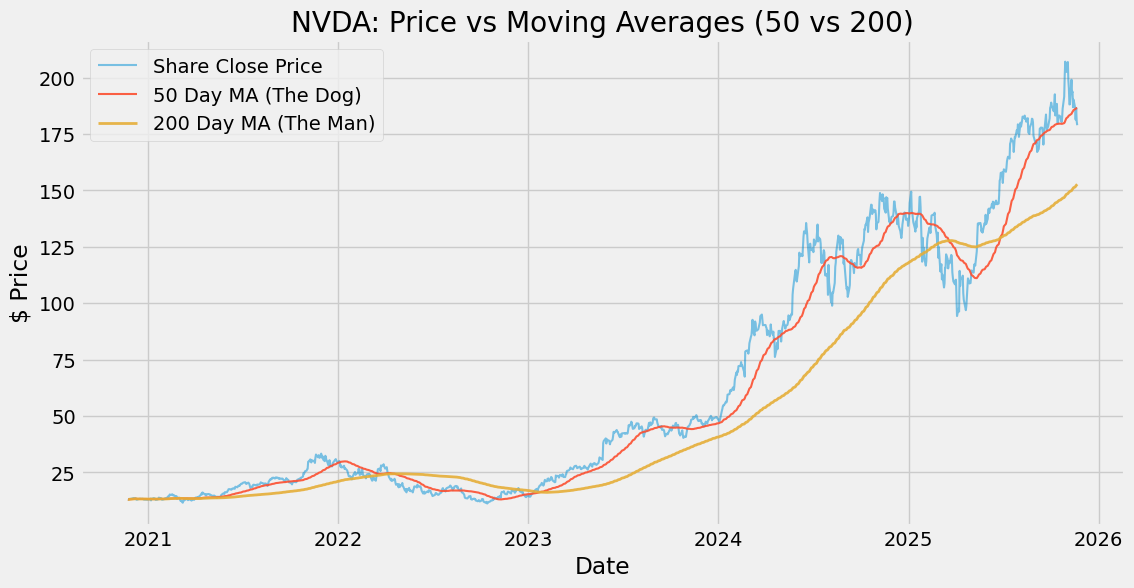

In [97]:
# Assuming you have run the widget cells and the TICKER variable is set globally
# Assuming 'data' DataFrame has 'Close', 'Short_MA', and 'Long_MA' columns

import matplotlib.pyplot as plt

def plot_ma_crossover(data, ticker, short_window, long_window):
    """Generates a plot showing the stock price and the two Moving Averages."""
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the Price, Short MA, and Long MA
    ax.plot(data['Close'], label='Share Close Price', linewidth=1.5,alpha=0.5)
    ax.plot(data['Short_MA'], label=f'{short_window} Day MA (The Dog)', linewidth=1.5,alpha=0.9)
    ax.plot(data['Long_MA'], label=f'{long_window} Day MA (The Man)', linewidth=2.0,alpha=0.9)
    
    # Set the dynamic title using f-strings
    ax.set_title(f'{ticker}: Price vs Moving Averages ({short_window} vs {long_window})')
    
    # Add labels and legend
    ax.set_xlabel('Date')
    ax.set_ylabel('$ Price')
    ax.legend(loc='best')
    
    plt.grid(True)
    plt.show()

# plot_ma_crossover(data, TICKER, SHORT_WINDOW, LONG_WINDOW)
plot_ma_crossover(data, TICKER, 50, 200)
# plot_ma_crossover(data, TICKER, 20, 100)    

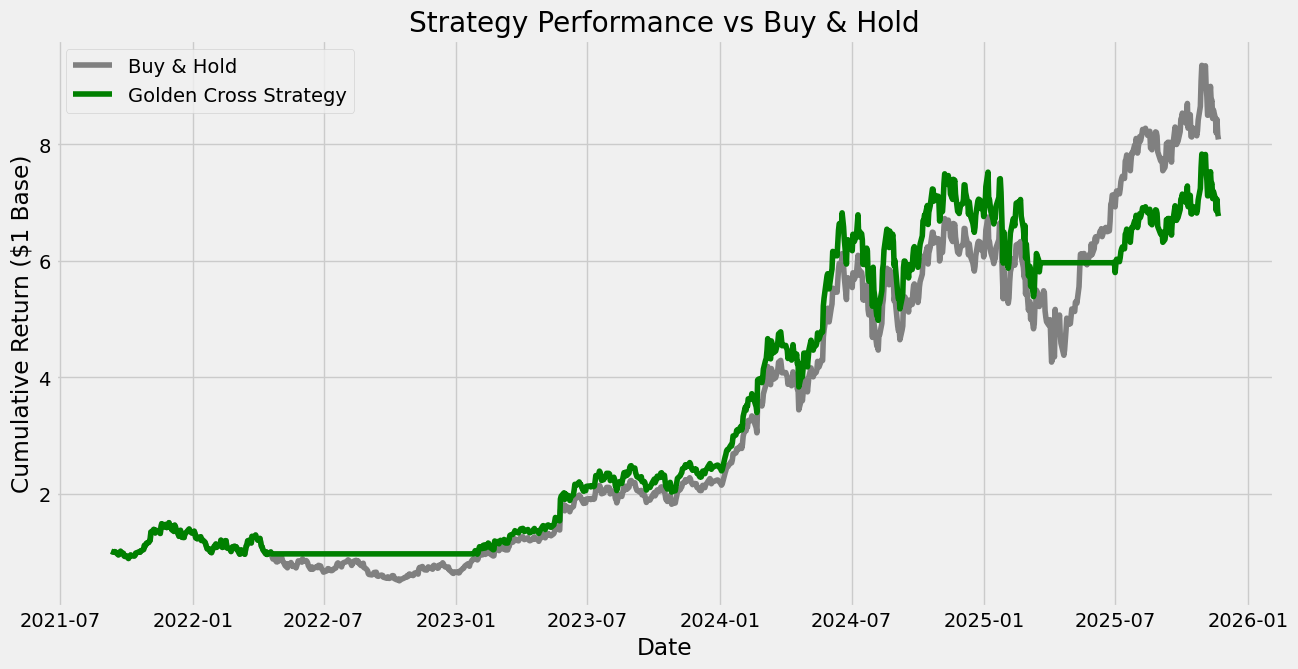

In [98]:
# Plot 2: Equity Curve (Money earned)
plt.figure(figsize=(14, 7))

plt.plot(df['Cumulative_Market_Returns'], label='Buy & Hold', color='gray')
plt.plot(df['Cumulative_Strategy_Returns'], label='Golden Cross Strategy', color='green')

plt.title('Strategy Performance vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return ($1 Base)')
plt.legend(loc='upper left')
plt.show()

## 7. Final Summary and Interpretation

### Analyzing the Results

Look at the **Equity Curve** plot above.
1.  **Trending Markets:** When the grey line (Market) goes straight up for a long time, our Green line (Strategy) usually keeps up. The "Dog" stays ahead of the "Man".
2.  **Sideways/Choppy Markets:** If the grey line moves flat or wobbles up and down, our strategy often **loses money**. Why? 
    *   *The Whipsaw Effect:* The market goes up, we buy. The market immediately goes down, we sell. We keep buying high and selling low.

### Pros and Cons

| Pros | Cons |
| :--- | :--- |
| **Easy to automate:** The logic is simple math. | **Lagging Indicator:** Moving averages look at the *past*. You will always buy slightly *after* the bottom and sell *after* the top. |
| **Catches big trends:** If the market crashes (like 2020 or 2022), the "Death Cross" gets you out of the market, saving you from huge losses. | **False Signals:** In a flat market, you pay lots of transaction fees for no gain. |

### Next Steps for Learners
*   Try changing `SMA50` and `SMA200` to different numbers (e.g., 20 and 100). Does it work better?
*   Try a different ticker symbol (e.g., "BTC-USD" for Bitcoin or "AAPL" for Apple).